# Airport Clustering Based on Delay Patterns
## Objective: Cluster airports by their monthly delay patterns

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# Initialize Spark session
spark = SparkSession \
    .builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

In [18]:
# Read in data
flights_2018 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2018.parquet')
flights_2019 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2019.parquet')
flights_2020 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2020.parquet')
flights_2021 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2021.parquet')
flights_2022 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2022.parquet')

## Step 1: Data Transformation for Airport Clustering
Transform data so that:
- Each row = one airport (Origin)
- Each column = one year-month combination
- Cell value = proportion of delayed flights (ArrDel15 >= 1) for that airport in that month

In [19]:
# Combine all years, select relevant columns, drop missing values
combined = flights_2018.union(flights_2019).union(flights_2020).union(flights_2021).union(flights_2022) \
    .select('FlightDate', 'Origin', 'ArrDel15').dropna()

# Extract year and month from FlightDate
combined = combined.withColumn('Year', F.year('FlightDate')) \
                   .withColumn('Month', F.month('FlightDate')) \
                   .withColumn('YearMonth', F.concat_ws('-', F.col('Year'), F.lpad(F.col('Month'), 2, '0')))

# Group by airport (Origin) and YearMonth, calculate proportion of delayed flights
delay_prop = combined.groupBy('Origin', 'YearMonth') \
                .agg(F.mean('ArrDel15').alias('delay_proportion'))

# Pivot so each airport is a row and each YearMonth is a column
pivoted = delay_prop.groupBy('Origin') \
            .pivot('YearMonth') \
            .agg(F.first('delay_proportion')) \
            .orderBy('Origin')

# Fill NA values with 0 (assuming no delay data means no delays or no flights)
airport_data = pivoted.fillna(0)

print(f'Shape of transformed airport data: {airport_data.count()} rows, {len(airport_data.columns)} columns.')

[Stage 1665:=============================================>         (9 + 1) / 11]

Shape of transformed airport data: 388 rows, 56 columns.


## Step 2: Detect and Remove Outliers
First run k=2 to identify potential outliers, similar to Peninsula Airways case

In [20]:
# Create feature vector
feats = airport_data.columns[1:]  # Exclude 'Origin' column
assembler = VectorAssembler(inputCols=feats, outputCol='features')
dataset = assembler.transform(airport_data)

# Show dataset info
print(f'Total airports: {dataset.count()}')
print(f'Feature dimension: {len(feats)}')
dataset.select('Origin', 'features').show(5)

Total airports: 388
Feature dimension: 55


[Stage 1677:=============================================>         (9 + 1) / 11]

+------+--------------------+
|Origin|            features|
+------+--------------------+
|   ABE|[0.29056603773584...|
|   ABI|[0.0,0.0,0.0,0.0,...|
|   ABQ|[0.14179566563467...|
|   ABR|[0.13559322033898...|
|   ABY|[0.21794871794871...|
+------+--------------------+
only showing top 5 rows



In [21]:
# Run KMeans with k=2 to detect outliers
kmeans_outlier = KMeans().setK(2).setSeed(314).setMaxIter(20)
model_outlier = kmeans_outlier.fit(dataset)
preds_outlier = model_outlier.transform(dataset)

# Check cluster distribution
cluster_counts = preds_outlier.groupBy('prediction').count().orderBy('count')
print('\nCluster distribution:')
cluster_counts.show()

# Identify minority cluster as potential outliers
minority_cluster = cluster_counts.first()['prediction']
print(f'\nMinority cluster (potential outliers): Cluster {minority_cluster}')

# Show airports in minority cluster
outliers = preds_outlier.filter(F.col('prediction') == minority_cluster).select('Origin')
print(f'\nAirports identified as outliers ({outliers.count()} airports):')
outliers.show(50, truncate=False)


Cluster distribution:


+----------+-----+
|prediction|count|
+----------+-----+
|         1|    3|
|         0|  385|
+----------+-----+




Minority cluster (potential outliers): Cluster 1



Airports identified as outliers (3 airports):


[Stage 1819:=============================================>         (9 + 1) / 11]

+------+
|Origin|
+------+
|ADK   |
|OGD   |
|PPG   |
+------+



In [22]:
# Remove outliers from dataset
outlier_list = [row['Origin'] for row in outliers.collect()]
dataset_clean = dataset.filter(~F.col('Origin').isin(outlier_list))

print(f'Original dataset: {dataset.count()} airports')
print(f'Cleaned dataset: {dataset_clean.count()} airports')
print(f'Removed: {len(outlier_list)} airports')

Original dataset: 388 airports


[Stage 1851:=============================================>         (9 + 1) / 11]

Cleaned dataset: 385 airports
Removed: 3 airports


## Step 3: Find Optimal k (from 2 to 10)
Use silhouette score to evaluate different k values

In [23]:
# Function to test different k values
def kmeans_range(lower, upper, data):
    """
    Test KMeans clustering with k from lower to upper
    Returns DataFrame with k and corresponding silhouette scores
    """
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop through k values
    for k in range(lower, upper+1, 1):
        print(f'Testing k={k}...')
        
        # Instantiate KMeans with current k
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit model
        model = kmeans.fit(data)
        
        # Predict clusters
        predictions = model.transform(data)
        
        # Evaluate with silhouette score
        silhouette = evaluator.evaluate(predictions)
        
        # Append results
        output = pd.concat([output, pd.DataFrame({'k': [k], 'silhouette': [silhouette]})], 
                          ignore_index=True)
        
        print(f'  Silhouette score: {silhouette:.4f}')
    
    return output

In [24]:
# Test k from 2 to 10
results = kmeans_range(2, 10, dataset_clean)
print('\nResults summary:')
print(results)

Testing k=2...


  Silhouette score: 0.3697
Testing k=3...


  Silhouette score: 0.3513
Testing k=4...


  Silhouette score: 0.3316
Testing k=5...


  Silhouette score: 0.3097
Testing k=6...


  Silhouette score: 0.2389
Testing k=7...


  Silhouette score: 0.1655
Testing k=8...


  Silhouette score: 0.3378
Testing k=9...


  Silhouette score: 0.2495
Testing k=10...


[Stage 3125:=============================================>         (9 + 1) / 11]

  Silhouette score: 0.2147

Results summary:
    k  silhouette
0   2    0.369697
1   3    0.351261
2   4    0.331589
3   5    0.309716
4   6    0.238861
5   7    0.165480
6   8    0.337783
7   9    0.249485
8  10    0.214698


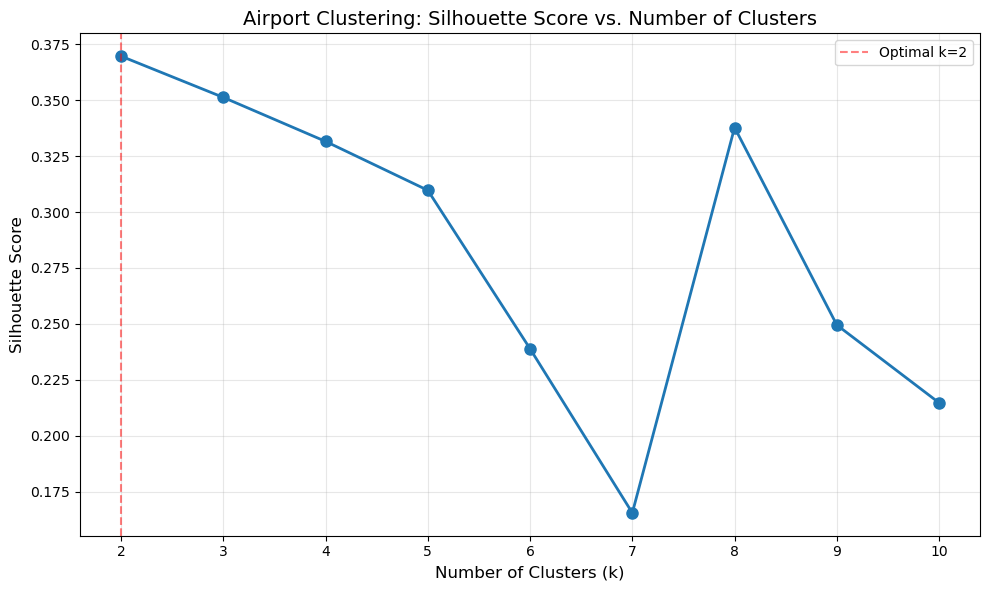


Optimal k: 2 with silhouette score: 0.3697


In [25]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(results['k'], results['silhouette'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Airport Clustering: Silhouette Score vs. Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))

# Mark optimal k
optimal_k = results.loc[results['silhouette'].idxmax(), 'k']
optimal_score = results['silhouette'].max()
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={int(optimal_k)}')
plt.legend()
plt.tight_layout()
plt.show()

print(f'\nOptimal k: {int(optimal_k)} with silhouette score: {optimal_score:.4f}')

## Step 4: Final Clustering with Optimal k

In [26]:
# Use optimal k for final clustering
optimal_k_int = int(optimal_k)
kmeans_final = KMeans().setK(optimal_k_int).setSeed(314).setMaxIter(20)
model_final = kmeans_final.fit(dataset_clean)
predictions_final = model_final.transform(dataset_clean)

# Show cluster assignments
print(f'\nFinal clustering results (k={optimal_k_int}):')
predictions_final.select('Origin', 'prediction').orderBy('prediction', 'Origin').show(50, truncate=False)


Final clustering results (k=2):


[Stage 3234:=============================================>         (9 + 1) / 11]

+------+----------+
|Origin|prediction|
+------+----------+
|ABE   |0         |
|ABQ   |0         |
|ACV   |0         |
|ACY   |0         |
|AEX   |0         |
|ALB   |0         |
|AMA   |0         |
|ASE   |0         |
|ATL   |0         |
|ATW   |0         |
|AUS   |0         |
|AVL   |0         |
|AVP   |0         |
|AZA   |0         |
|AZO   |0         |
|BDL   |0         |
|BET   |0         |
|BFF   |0         |
|BGR   |0         |
|BHM   |0         |
|BIL   |0         |
|BIS   |0         |
|BKG   |0         |
|BLV   |0         |
|BMI   |0         |
|BNA   |0         |
|BOS   |0         |
|BQN   |0         |
|BRW   |0         |
|BTR   |0         |
|BTV   |0         |
|BUF   |0         |
|BUR   |0         |
|BWI   |0         |
|BZN   |0         |
|CAE   |0         |
|CAK   |0         |
|CGI   |0         |
|CHA   |0         |
|CHO   |0         |
|CHS   |0         |
|CID   |0         |
|CKB   |0         |
|CLE   |0         |
|CLT   |0         |
|CMH   |0         |
|CMI   |0         |


In [27]:
# Cluster size distribution
cluster_distribution = predictions_final.groupBy('prediction') \
    .agg(F.count('Origin').alias('airport_count')) \
    .orderBy('prediction')

print('\nCluster size distribution:')
cluster_distribution.show()

# Show sample airports from each cluster
print('\nSample airports from each cluster:')
for cluster_id in range(optimal_k_int):
    print(f'\n--- Cluster {cluster_id} ---')
    predictions_final.filter(F.col('prediction') == cluster_id) \
        .select('Origin') \
        .limit(10) \
        .show(truncate=False)


Cluster size distribution:


+----------+-------------+
|prediction|airport_count|
+----------+-------------+
|         0|          254|
|         1|          131|
+----------+-------------+


Sample airports from each cluster:

--- Cluster 0 ---


+------+
|Origin|
+------+
|ABE   |
|ABQ   |
|ACV   |
|ACY   |
|AEX   |
|ALB   |
|AMA   |
|ASE   |
|ATL   |
|ATW   |
+------+


--- Cluster 1 ---


[Stage 3278:=============================================>         (9 + 1) / 11]

+------+
|Origin|
+------+
|ABI   |
|ABR   |
|ABY   |
|ACK   |
|ACT   |
|ADQ   |
|AGS   |
|AKN   |
|ALO   |
|ALS   |
+------+



## Step 5: Analyze Cluster Characteristics
Calculate average delay proportion for each cluster to understand their patterns


Average delay proportion by cluster (sorted by delay rate):
Cluster 0: 0.1711 (254 routes)
Cluster 1: 0.1074 (131 routes)


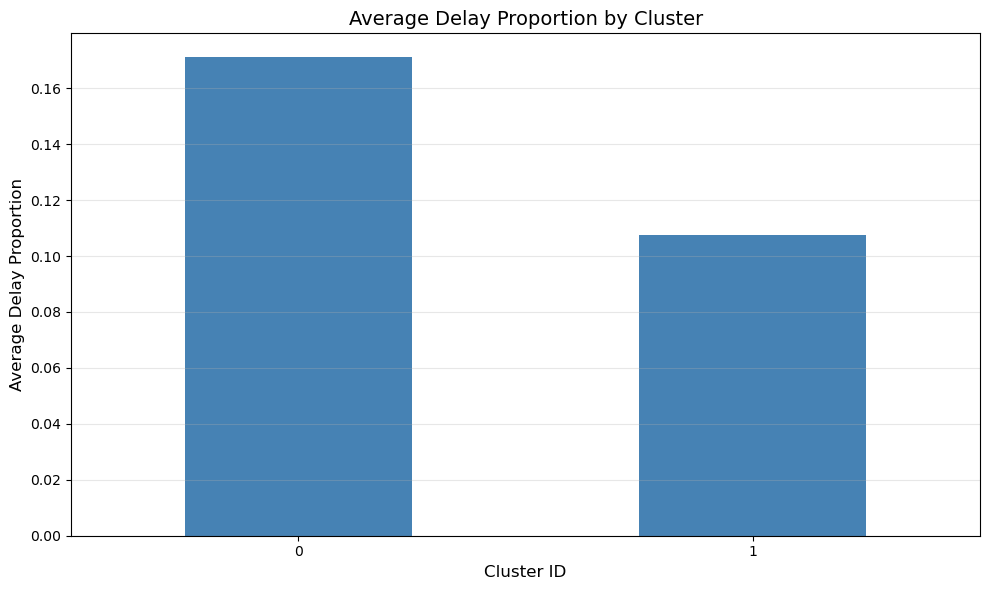

In [45]:
# Calculate mean delay proportion across all months for each cluster
predictions_pd = predictions_final.toPandas()

# Calculate average delay proportion per cluster
cluster_stats = predictions_pd.groupby('prediction')[feats].mean().mean(axis=1)
cluster_stats = cluster_stats.sort_values(ascending=False)

print('\nAverage delay proportion by cluster (sorted by delay rate):')
for cluster_id, avg_delay in cluster_stats.items():
    count = len(predictions_pd[predictions_pd['prediction'] == cluster_id])
    print(f'Cluster {cluster_id}: {avg_delay:.4f} ({count} routes)')

# Visualize cluster delay patterns
plt.figure(figsize=(10, 6))
cluster_stats.plot(kind='bar', color='steelblue')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Average Delay Proportion', fontsize=12)
plt.title('Average Delay Proportion by Cluster', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Step 6: Save Results

In [28]:
# Convert to pandas for easier analysis
airport_clusters_pd = predictions_final.select('Origin', 'prediction').toPandas()
airport_clusters_pd.columns = ['Airport', 'Cluster']
airport_clusters_pd = airport_clusters_pd.sort_values(['Cluster', 'Airport'])

print(f'\nTotal airports clustered: {len(airport_clusters_pd)}')
print(f'Number of clusters: {optimal_k_int}')
print('\nFirst 20 rows:')
print(airport_clusters_pd.head(20))

# Save to CSV
airport_clusters_pd.to_csv('airport_clusters.csv', index=False)
print('\nResults saved to: airport_clusters.csv')

[Stage 3291:=============================================>         (9 + 1) / 11]


Total airports clustered: 385
Number of clusters: 2

First 20 rows:
   Airport  Cluster
0      ABE        0
2      ABQ        0
7      ACV        0
8      ACY        0
10     AEX        0
13     ALB        0
17     AMA        0
21     ASE        0
22     ATL        0
23     ATW        0
25     AUS        0
26     AVL        0
27     AVP        0
28     AZA        0
29     AZO        0
30     BDL        0
31     BET        0
32     BFF        0
36     BGR        0
37     BHM        0

Results saved to: airport_clusters.csv


In [29]:
# Save silhouette scores
results.to_csv('airport_clustering_silhouette_scores.csv', index=False)
print('Silhouette scores saved to: airport_clustering_silhouette_scores.csv')

Silhouette scores saved to: airport_clustering_silhouette_scores.csv
